In [ ]:
import numpy as np
import matplotlib.pyplot as plt

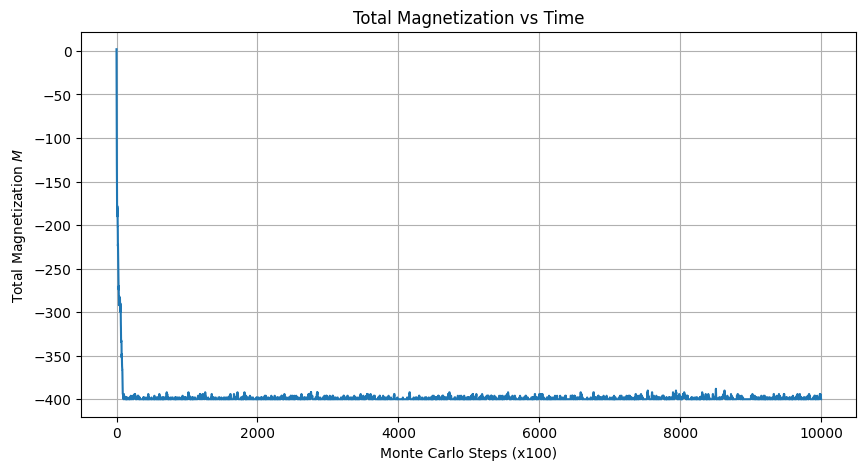

In [ ]:
L = 20
J = 1
T = 1
steps = 1000000

lattice = np.random.choice([1, -1], size=(L, L))

def calculate_total_energy(s):

    right_neighbors = np.sum(s[:, :-1] * s[:, 1:])
    down_neighbors = np.sum(s[:-1, :] * s[1:, :])

    total_energy = -J * (right_neighbors + down_neighbors)
    return total_energy

def get_energy_change(s, i, j):

    spin = s[i, j]
    neighbors = 0
    if i > 0: neighbors += s[i-1, j]
    if i < L-1: neighbors += s[i+1, j]
    if j > 0: neighbors += s[i, j-1]
    if j < L-1: neighbors += s[i, j+1]


    return 2 * J * spin * neighbors


magnetization_history = []

for step in range(steps):

    i, j = np.random.randint(0, L, size=2)


    delta_E = get_energy_change(lattice, i, j)


    if delta_E <= 0 or np.random.random() < np.exp(-delta_E / T):
        lattice[i, j] *= -1

    if step % 100 == 0:
        magnetization_history.append(np.sum(lattice))


plt.figure(figsize=(10, 5))
plt.plot(magnetization_history)
plt.title(f"Total Magnetization vs Time")
plt.xlabel("Monte Carlo Steps (x100)")
plt.ylabel("Total Magnetization $M$")
plt.grid(True)
plt.show()


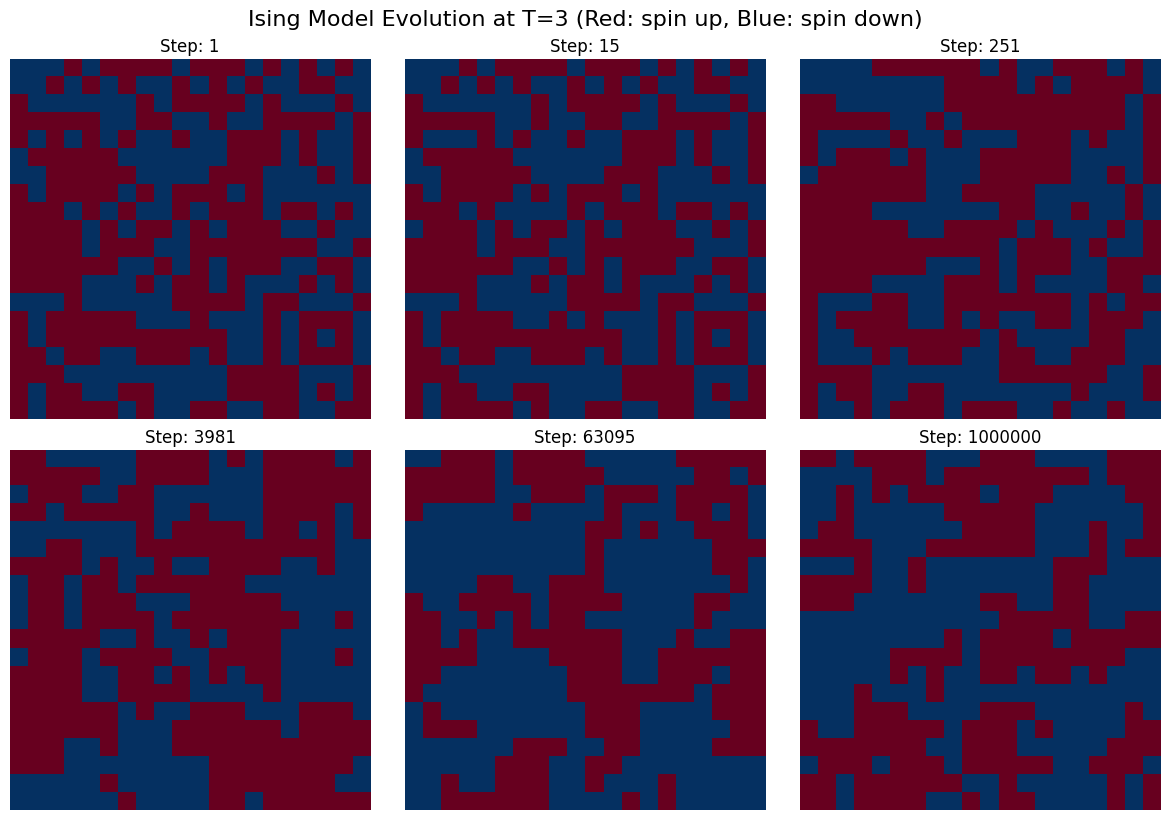

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


L = 20
J = 1
T = 3
total_steps = 1000000


snapshots_at = np.logspace(0, np.log10(total_steps), 6).astype(int)


lattice = np.random.choice([1, -1], size=(L, L))

def get_energy_change(s, i, j):
    spin = s[i, j]
    neighbors = 0
    if i > 0: neighbors += s[i-1, j]
    if i < L-1: neighbors += s[i+1, j]
    if j > 0: neighbors += s[i, j-1]
    if j < L-1: neighbors += s[i, j+1]
    return 2 * J * spin * neighbors


fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
snapshot_idx = 0


for step in range(1, total_steps + 1):
    i, j = np.random.randint(0, L, size=2)
    delta_E = get_energy_change(lattice, i, j)


    if delta_E <= 0 or np.random.random() < np.exp(-delta_E / T):
        lattice[i, j] *= -1


    if step in snapshots_at and snapshot_idx < 6:
        ax = axes[snapshot_idx]
        ax.imshow(lattice, cmap='RdBu', interpolation='nearest', vmin=-1, vmax=1)
        ax.set_title(f"Step: {step}")
        ax.axis('off')
        snapshot_idx += 1

plt.tight_layout()
plt.suptitle(f"Ising Model Evolution at T={T} (Red: spin up, Blue: spin down)", fontsize=16, y=1.02)
plt.show()

fastest  tau=    1000.0  final dimers=1136
faster  tau=    5000.0  final dimers=1137
fast    tau=   10000.0  final dimers=1138
medium  tau=  100000.0  final dimers=1175
slow    tau=  500000.0  final dimers=1137


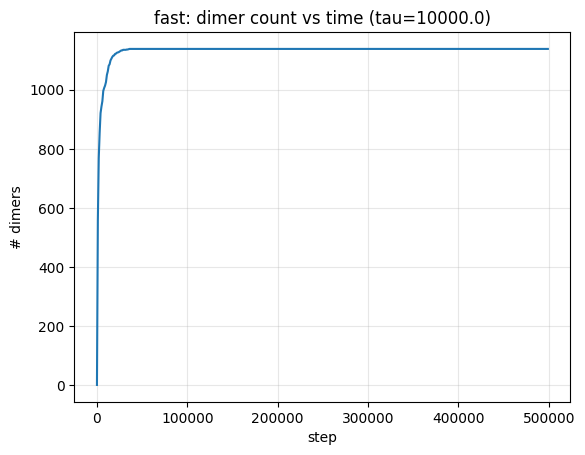

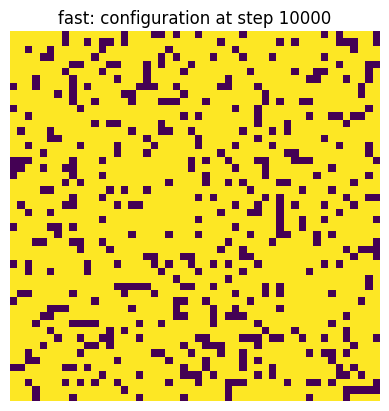

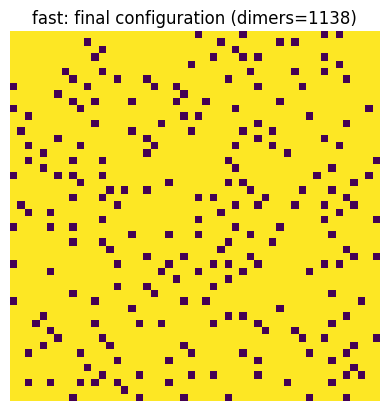

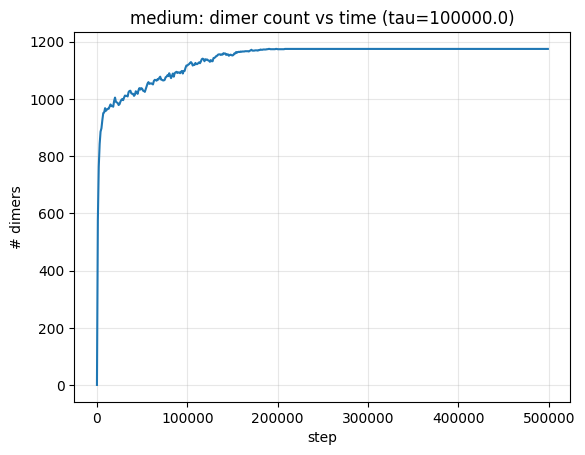

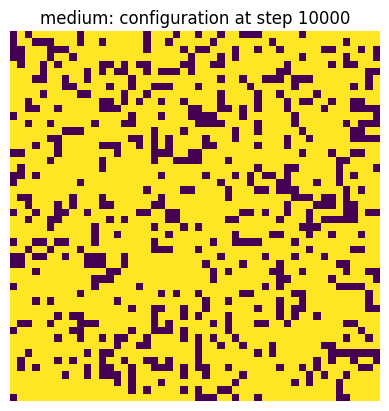

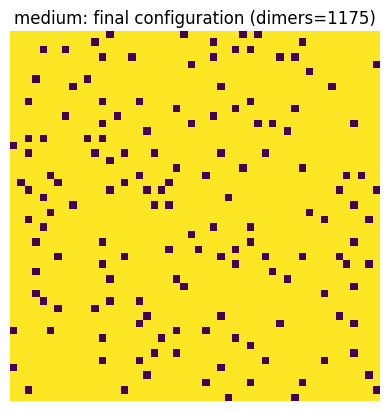

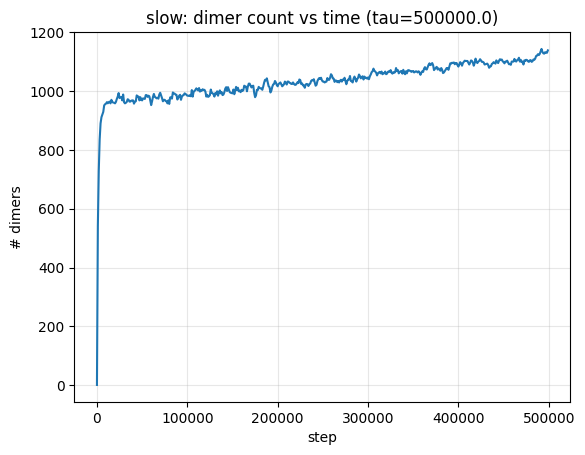

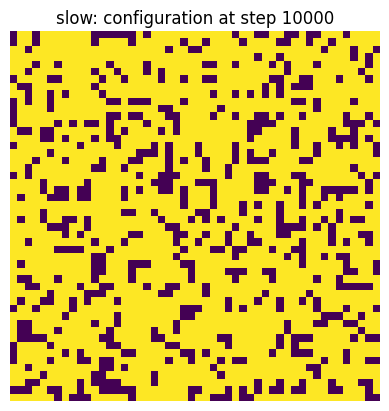

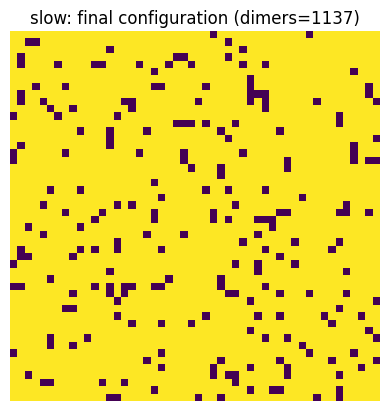

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def random_bond(rng, L):
    if rng.integers(0, 2) == 0:
        r = rng.integers(0, L)
        c = rng.integers(0, L - 1)
        return (r, c), (r, c + 1)
    else:
        r = rng.integers(0, L - 1)
        c = rng.integers(0, L)
        return (r, c), (r + 1, c)

def run_anneal(L=50, total_steps=1_000_000, T_max=1.0, T_min=0.01,
              tau=None, seed=0, record_every=1000, snapshot_steps=(10_000,)):
    rng = np.random.default_rng(seed)

    if tau is None:
        tau = total_steps / np.log(T_max / T_min)

    grid = np.zeros((L, L), dtype=np.int32)
    dimer_id = 1
    dimer_count = 0

    history = np.empty(total_steps // record_every + 1, dtype=np.int32)
    temps   = np.empty_like(history, dtype=np.float64)
    k = 0

    snapshot_steps = set(int(s) for s in snapshot_steps)
    snapshots = {}

    for step in range(total_steps):

        T = T_max * np.exp(-step / tau)
        if T < T_min:
            T = T_min

        p1, p2 = random_bond(rng, L)
        v1 = grid[p1]
        v2 = grid[p2]

        if v1 == 0 and v2 == 0:
            grid[p1] = grid[p2] = dimer_id
            dimer_id += 1
            dimer_count += 1

        elif v1 > 0 and v1 == v2:
            if rng.random() < np.exp(-1.0 / T):
                grid[p1] = 0
                grid[p2] = 0
                dimer_count -= 1

        if step in snapshot_steps and step not in snapshots:
            snapshots[step] = grid.copy()

        if step % record_every == 0:
            history[k] = dimer_count
            temps[k] = T
            k += 1

    return {
        "grid": grid,
        "history": history[:k],
        "temps": temps[:k],
        "tau": tau,
        "final_dimers": int(dimer_count),
        "snapshots": snapshots,
        "record_every": record_every,
    }


L = 50
total_steps = 500_000
T_max = 1.0
T_min = 0.01
record_every = 1000
snapshot_step = 10_000

tau_base = total_steps / np.log(T_max / T_min)

schedules = {
    "fastest": 1000,
    "faster":   5000,
    "fast":   10_000,
    "medium": 100000,
    "slow":   500000,
}


results = {}
for i, (name, tau) in enumerate(schedules.items()):
    results[name] = run_anneal(
        L=L, total_steps=total_steps, T_max=T_max, T_min=T_min,
        tau=tau, seed=1234 + i, record_every=record_every,
        snapshot_steps=(snapshot_step,)
    )
    print(f"{name:6s}  tau={tau:10.1f}  final dimers={results[name]['final_dimers']}")


for name in ["fast", "medium", "slow"]:
    res = results[name]
    hist = res["history"]
    tau  = res["tau"]
    rec  = res["record_every"]
    early = res["snapshots"].get(snapshot_step, None)
    final = res["grid"]


    plt.figure()
    plt.plot(np.arange(len(hist)) * rec, hist)
    plt.xlabel("step")
    plt.ylabel("# dimers")
    plt.title(f"{name}: dimer count vs time (tau={tau:.1f})")
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure()
    if early is None:
        plt.text(0.5, 0.5, f"No snapshot saved at step {snapshot_step}",
                 ha="center", va="center")
        plt.axis("off")
    else:
        plt.imshow(early > 0, interpolation="nearest")
        plt.title(f"{name}: configuration at step {snapshot_step}")
        plt.axis("off")
    plt.show()

    plt.figure()
    plt.imshow(final > 0, interpolation="nearest")
    plt.title(f"{name}: final configuration (dimers={res['final_dimers']})")
    plt.axis("off")
    plt.show()


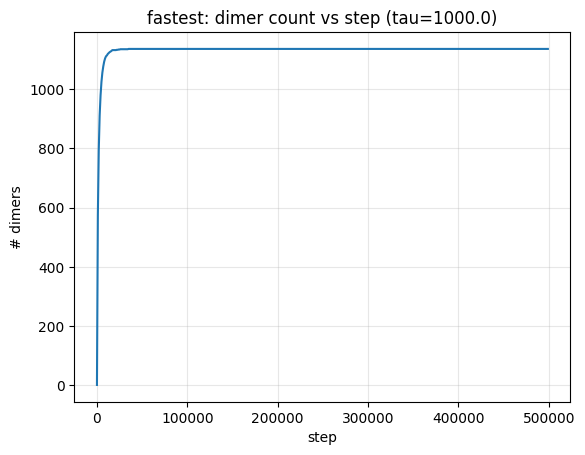

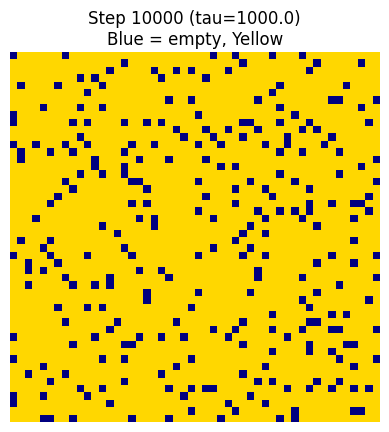

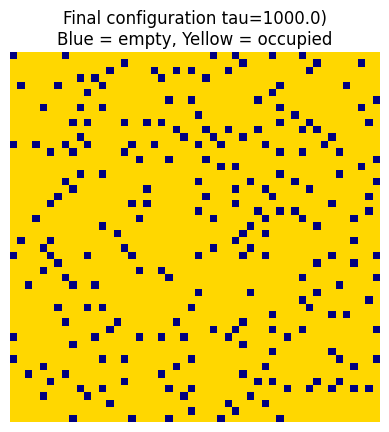

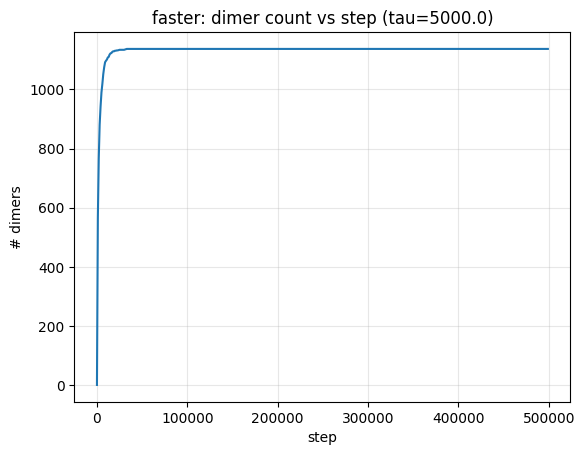

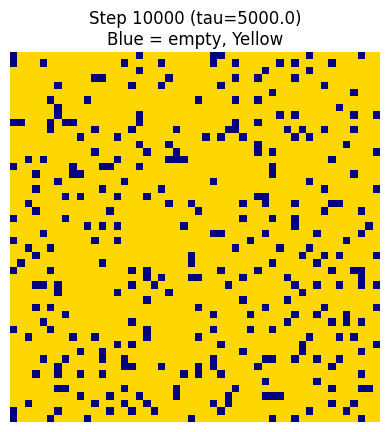

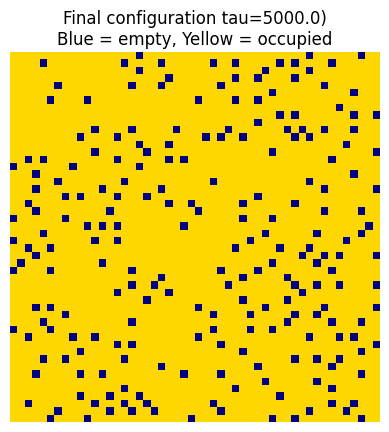

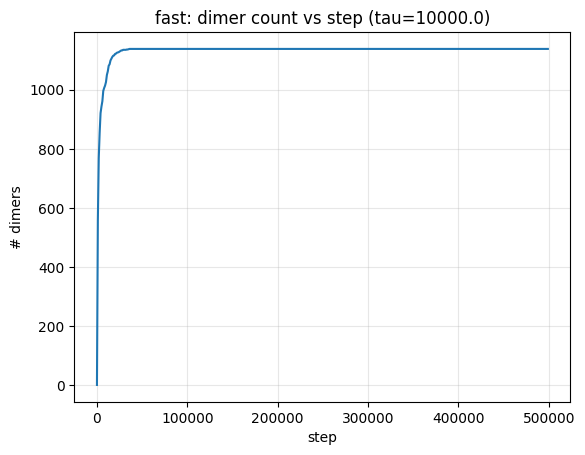

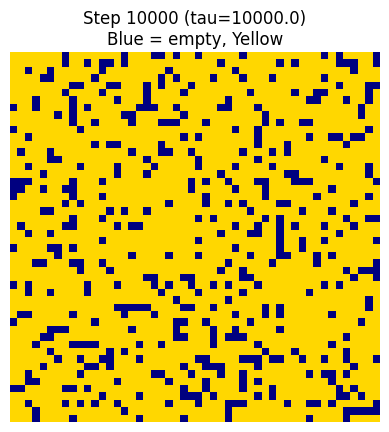

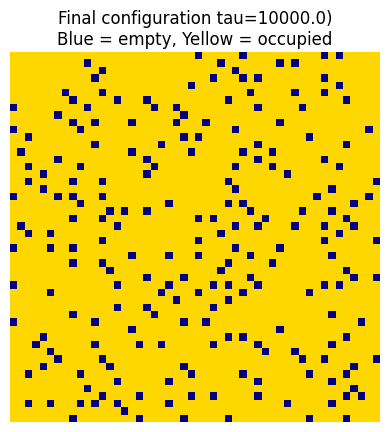

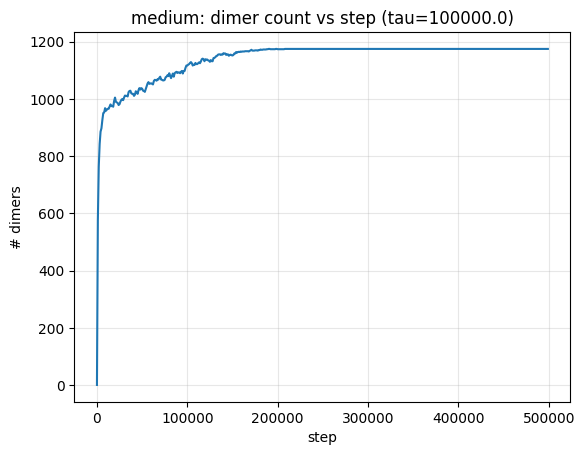

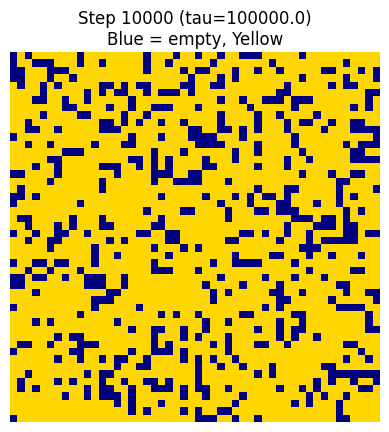

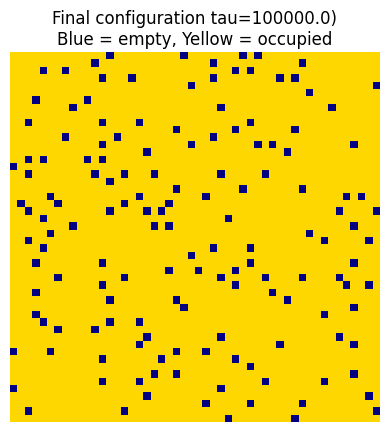

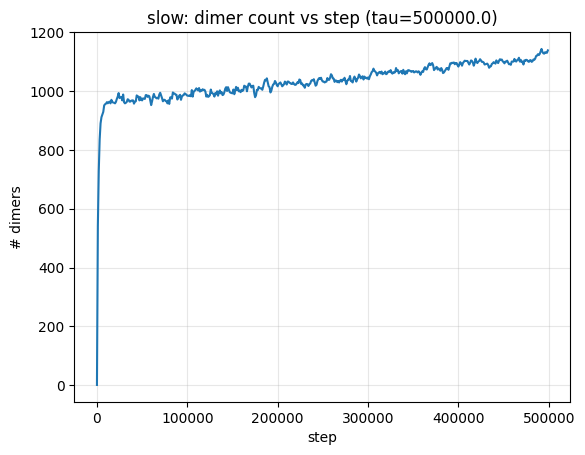

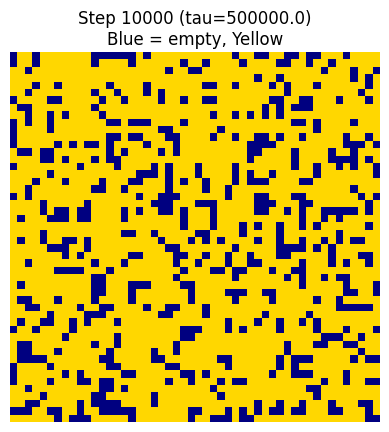

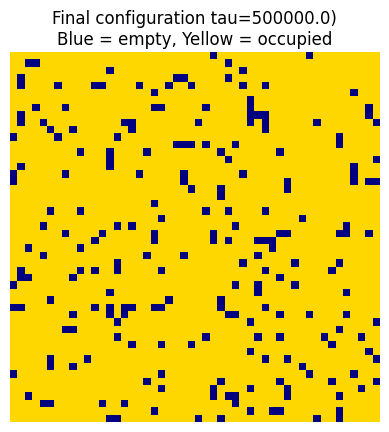

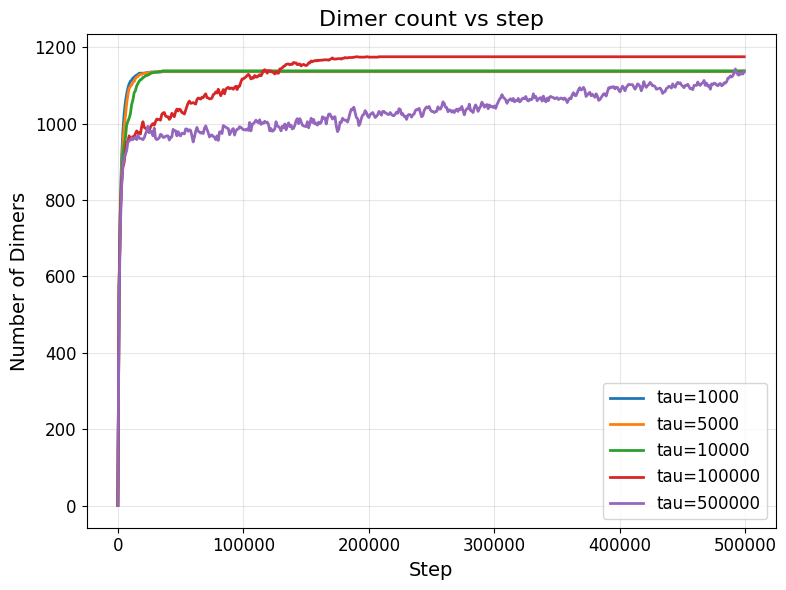

In [ ]:
from matplotlib.colors import ListedColormap


cmap2 = ListedColormap(["navy", "gold"])

run_order = list(schedules.keys())


for name in run_order:
    res = results[name]
    hist = res["history"]
    tau  = res["tau"]
    rec  = res["record_every"]
    early = res["snapshots"].get(snapshot_step, None)
    final = res["grid"]


    plt.figure()
    steps_axis = np.arange(len(hist)) * rec
    plt.plot(steps_axis, hist)
    plt.xlabel("step")
    plt.ylabel("# dimers")
    plt.title(f"{name}: dimer count vs step (tau={tau:.1f})")
    plt.grid(True, alpha=0.3)
    plt.show()


    plt.figure()
    if early is None:
        plt.text(0.5, 0.5, f"No snapshot saved at step {snapshot_step}",
                 ha="center", va="center")
        plt.axis("off")
    else:
        occ = (early > 0).astype(int)
        plt.imshow(occ, interpolation="nearest", cmap=cmap2, vmin=0, vmax=1)
        plt.title(
            f"Step {snapshot_step} (tau={tau:.1f})\n"
            "Blue = empty, Yellow"
        )
        plt.axis("off")
    plt.show()


    plt.figure()
    occf = (final > 0).astype(int)
    plt.imshow(occf, interpolation="nearest", cmap=cmap2, vmin=0, vmax=1)
    plt.title(
        f"Final configuration tau={tau:.1f})\n"
        "Blue = empty, Yellow = occupied"
    )
    plt.axis("off")
    plt.show()

plt.figure(figsize=(8, 6))

for name in run_order:
    hist = results[name]["history"]
    rec  = results[name]["record_every"]
    steps_axis = np.arange(len(hist)) * rec
    plt.plot(steps_axis, hist, linewidth=2,
             label=f"tau={results[name]['tau']:.0f}")

plt.xlabel("Step", fontsize=14)
plt.ylabel("Number of Dimers", fontsize=14)
plt.title("Dimer count vs step", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()



In [ ]:

m = 2**32
a = 1664525
c = 1013904223
state = 42

def lcg_random(number):
    number = (a * number + c) % m
    return number / m

iteration = 0
iteration_length = 10
starting_num_seed = 42
while iteration < iteration_length:
    starting_num_seed = lcg_random(starting_num_seed)
print(starting_num_seed)



KeyboardInterrupt: 

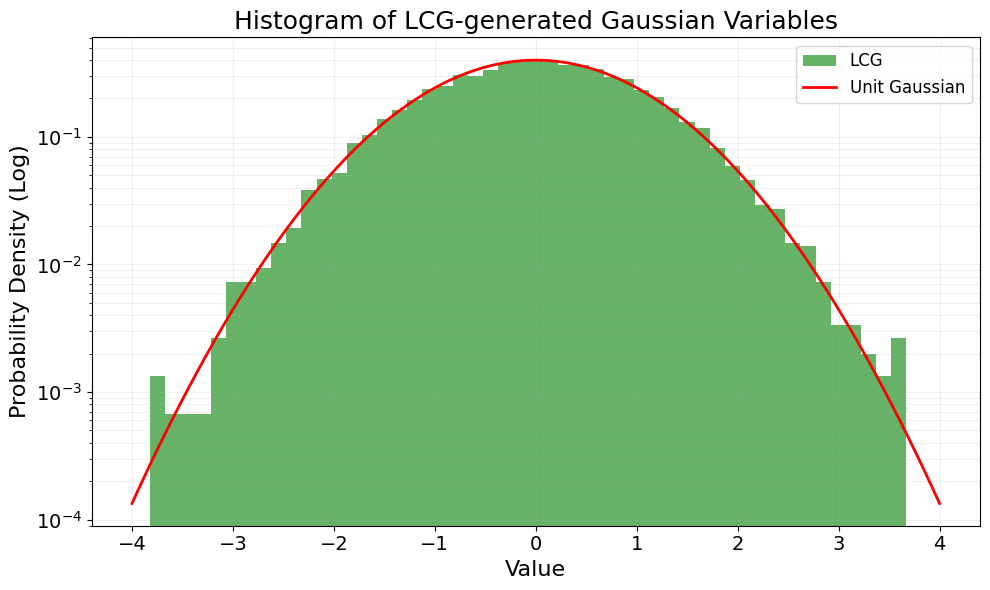

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


m = 2**32
a = 1664525
c = 1013904223

def lcg_random(number):

    next_seed = (a * number + c) % m
    return next_seed, next_seed / m

def generate_gaussian(seed):
    seed, u1 = lcg_random(seed)
    seed, u2 = lcg_random(seed)

    if u1 == 0: u1 = 1e-10

    z = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    return seed, z


num_values = 10000
gaussian_values = []
current_seed = 2

for _ in range(num_values):
    current_seed, val = generate_gaussian(current_seed)
    gaussian_values.append(val)

plt.figure(figsize=(10, 6))
plt.hist(gaussian_values, bins=50, density=True, alpha=0.6, color='g', label='LCG')


x = np.linspace(-4, 4, 100)
gaussian_theory = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)
plt.plot(x, gaussian_theory, 'r', lw=2, label='Unit Gaussian')

plt.yscale('log')

plt.title("Histogram of LCG-generated Gaussian Variables", fontsize=18)
plt.xlabel("Value", fontsize=16)
plt.ylabel("Probability Density (Log)", fontsize=16)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize=12)

plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

In [ ]:
def dft(y):
  N = len(y)
  c = np.zeros(N//2+1,complex)
  k_s = []
  for k in range(N//2+1):
    k_s.append(k)
    for n in range(N):
      c[k] += y[n]*np.exp(-2j*np.pi*k*n/N)
  return c,k_s

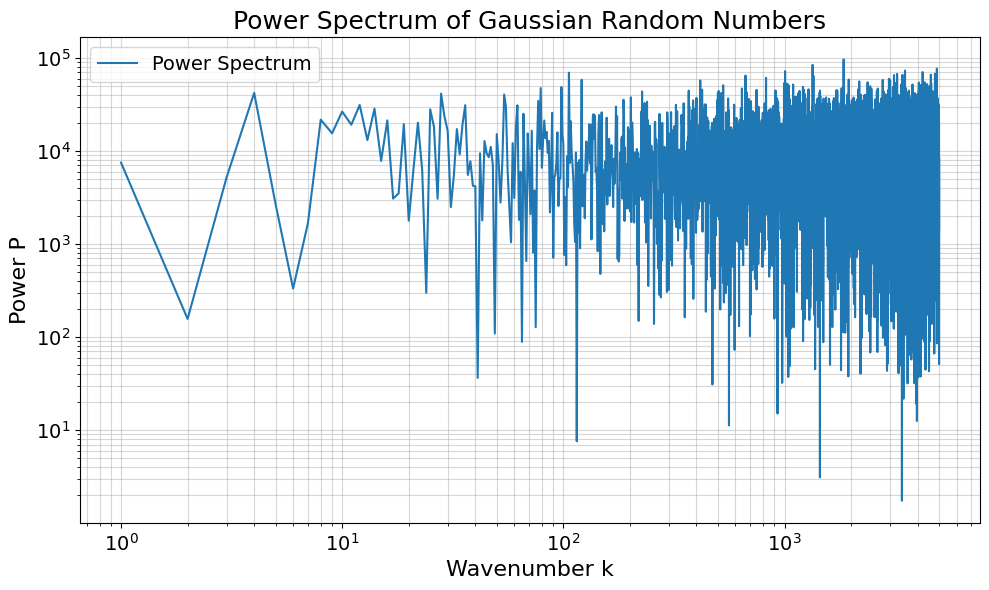

In [1]:
import numpy as np
import matplotlib.pyplot as plt


m = 2**32
a = 1664525
c = 1013904223

def lcg_random(number):
    next_seed = (a * number + c) % m
    return next_seed, next_seed / m

def generate_gaussian(seed):
    seed, u1 = lcg_random(seed)
    seed, u2 = lcg_random(seed)
    if u1 == 0: u1 = 1e-10
    z = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    return seed, z


num_values = 10000
gaussian_values = []
current_seed = 42
for _ in range(num_values):
    current_seed, val = generate_gaussian(current_seed)
    gaussian_values.append(val)


def dft(y):
    N = len(y)
    c = np.zeros(N//2+1, complex)
    k_s = []
    for k in range(N//2+1):
        k_s.append(k)
        for n in range(N):
            c[k] += y[n] * np.exp(-2j * np.pi * k * n / N)
    return c, k_s


coefficients, wavenumbers = dft(gaussian_values)


power_spectrum = np.abs(coefficients)**2


plt.figure(figsize=(10, 6))

plt.loglog(wavenumbers[1:], power_spectrum[1:], label='Power Spectrum')

plt.title("Power Spectrum of Gaussian Random Numbers", fontsize=18)
plt.xlabel("Wavenumber k", fontsize=16)
plt.ylabel("Power P", fontsize=16)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


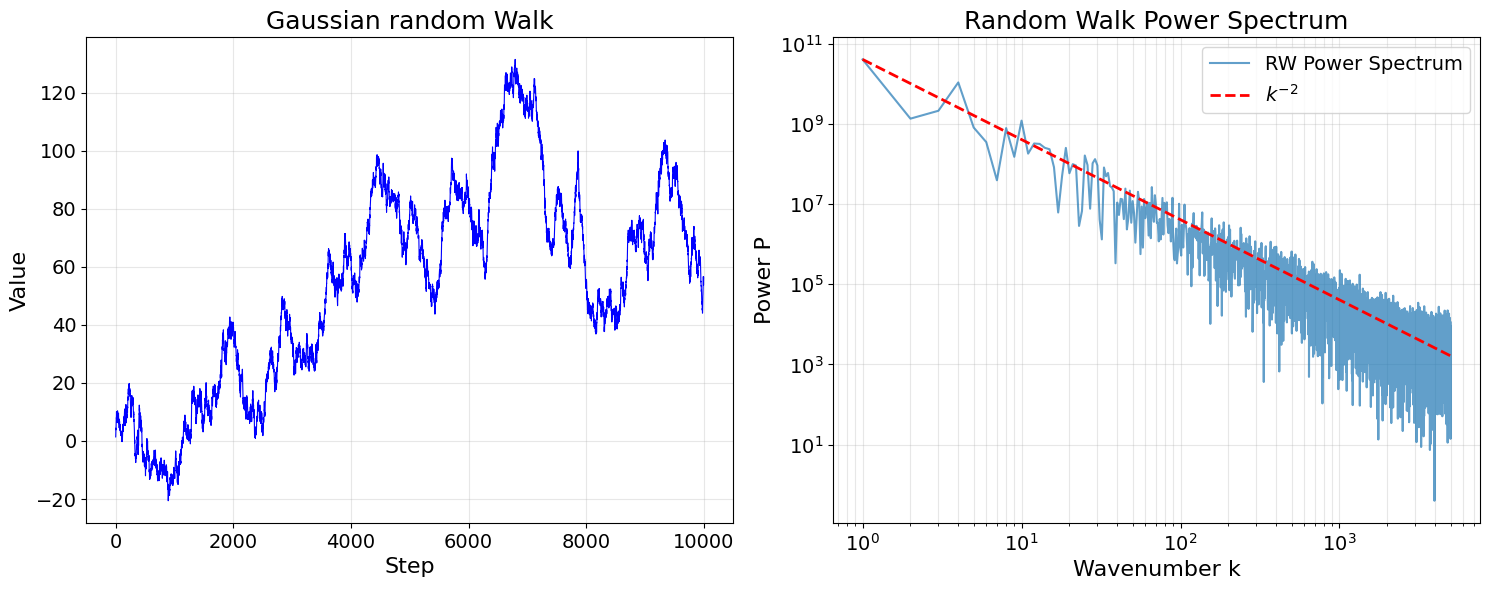

In [ ]:
m = 2**32
a = 1664525
c = 1013904223

def lcg_random(number):
    next_seed = (a * number + c) % m
    return next_seed, next_seed / m

def generate_gaussian(seed):
    seed, u1 = lcg_random(seed)
    seed, u2 = lcg_random(seed)
    if u1 == 0: u1 = 1e-10
    z = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    return seed, z

num_values = 10000
gaussian_steps = []
current_seed = 42
for _ in range(num_values):
    current_seed, val = generate_gaussian(current_seed)
    gaussian_steps.append(val)


random_walk = np.cumsum(gaussian_steps)

def dft(y):
    N = len(y)
    c = np.zeros(N//2+1, complex)
    k_s = np.arange(N//2+1)
    for k in range(N//2+1):

        n = np.arange(N)
        c[k] = np.sum(y * np.exp(-2j * np.pi * k * n / N))
    return c, k_s

coeffs_rw, k_rw = dft(random_walk)
power_rw = np.abs(coeffs_rw)**2


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


ax1.plot(random_walk, color='blue', lw=0.8)
ax1.set_title("Gaussian random Walk", fontsize=18)
ax1.set_xlabel("Step", fontsize=16)
ax1.set_ylabel("Value", fontsize=16)
ax1.tick_params(axis='both', labelsize=14)
ax1.grid(True, alpha=0.3)

ax2.loglog(k_rw[1:], power_rw[1:], label='RW Power Spectrum', alpha=0.7)


ref_k = k_rw[1:]
ref_p = power_rw[1] * (ref_k / ref_k[0])**-2
ax2.loglog(ref_k, ref_p, 'r--', lw=2, label=r'$k^{-2}$')

ax2.set_title("Random Walk Power Spectrum", fontsize=18)
ax2.set_xlabel("Wavenumber k", fontsize=16)
ax2.set_ylabel("Power P", fontsize=16)
ax2.tick_params(axis='both', labelsize=14)
ax2.legend(fontsize=14)
ax2.grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.show()
